In [1]:
import pandas as pd
url= "https://raw.githubusercontent.com/ManikaNagpal/Stock-Price-Prediction-using-LSTM/refs/heads/main/Netflix_Dataset.csv"
stock_data = pd.read_csv(url, index_col='Date')
stock_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
04-03-2019,359.72,362.25,348.04,351.04,"74,86,996"
05-03-2019,351.46,356.17,348.25,354.30,"59,37,754"
06-03-2019,353.60,359.88,351.70,359.61,"62,11,895"
07-03-2019,360.16,362.86,350.50,352.60,"61,51,331"
08-03-2019,345.75,349.92,342.47,349.60,"68,98,838"


## Exploratory Data Analysis

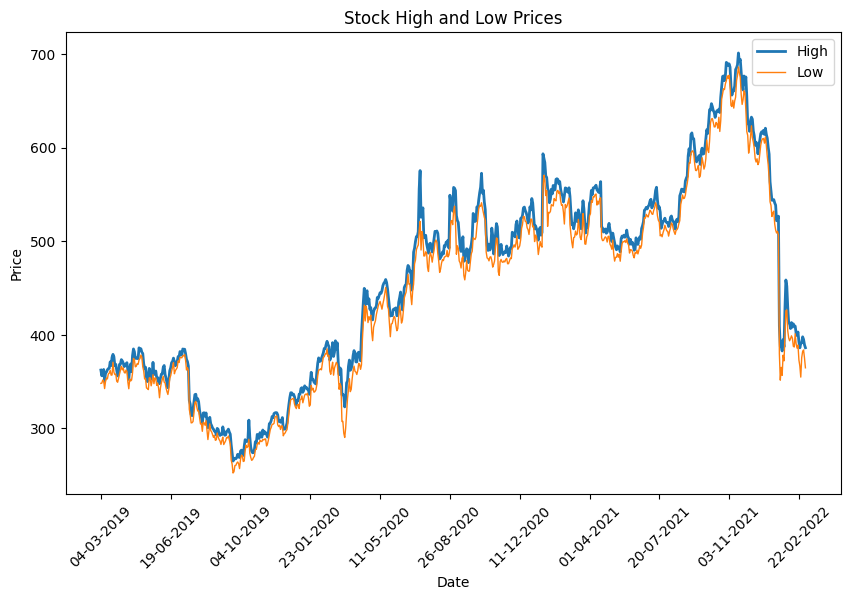

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(stock_data['High'], label='High', linewidth=2)
plt.plot(stock_data['Low'], label='Low', linewidth=1)

# Adding labels and title
plt.title('Stock High and Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotating the x-axis labels to avoid overlap
plt.xticks(rotation=45)

# Limiting the number of x-ticks for better readability
plt.xticks(stock_data.index[::len(stock_data)//10])  # You may adjust the step size based on your data size

# Show the plot
plt.show()

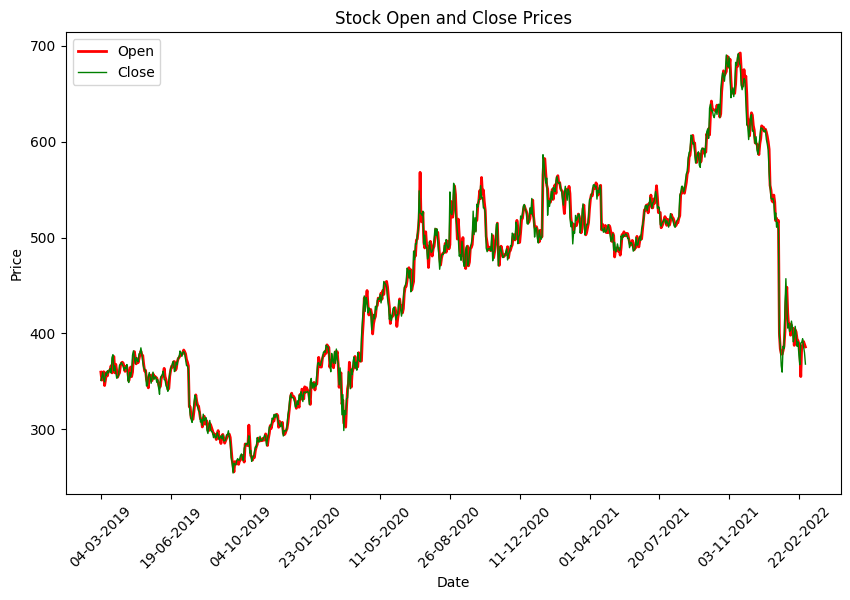

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Open'], label='Open', color='red', linewidth=2)
plt.plot(stock_data['Close'], label='Close', color='green', linewidth=1)

# Adding labels and title
plt.title('Stock Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotating the x-axis labels to avoid overlap
plt.xticks(rotation=45)

# Optionally, limit the number of x-ticks for better readability
plt.xticks(stock_data.index[::len(stock_data)//10])  # Adjust the step size based on your data size

# Show the plot
plt.show()

## Data Preprocessing

In [6]:
target_y = stock_data['Close']
X_feat = stock_data.iloc[:,0:3]
stock_data = stock_data[['Open', 'High', 'Low', 'Close']]

In [7]:
print(target_y)

Date
04-03-2019    351.04
05-03-2019    354.30
06-03-2019    359.61
07-03-2019    352.60
08-03-2019    349.60
               ...  
25-02-2022    390.80
28-02-2022    394.52
01-03-2022    386.24
02-03-2022    380.03
03-03-2022    368.07
Name: Close, Length: 758, dtype: float64


In [8]:
print(X_feat)

              Open    High     Low
Date                              
04-03-2019  359.72  362.25  348.04
05-03-2019  351.46  356.17  348.25
06-03-2019  353.60  359.88  351.70
07-03-2019  360.16  362.86  350.50
08-03-2019  345.75  349.92  342.47
...            ...     ...     ...
25-02-2022  386.61  391.29  375.58
28-02-2022  387.33  397.75  382.13
01-03-2022  391.60  395.00  383.71
02-03-2022  388.93  389.22  375.21
03-03-2022  386.00  386.12  364.65

[758 rows x 3 columns]


## Feature Scaling

In [9]:
sc = StandardScaler()
stock_data_ft = sc.fit_transform(stock_data.values)
stock_data_ft = pd.DataFrame(columns=stock_data.columns,
                            data=stock_data_ft,
                            index=stock_data.index)

## Defining the Split Function for LSTM

In [4]:
import numpy as np

In [16]:
print(len(stock_data))

758


```
data = [
   [f1, f2, f3, target],
   [f1, f2, f3, target],
   [f1, f2, f3, target],
   ...
]

```

In [10]:
def lstm_split(data, n_steps): # Extract a window of size `n_steps` for features
    x, y = [], []
    for i in range(len(data) - n_steps): #range is so because the last features will not be used in the feature matrix
        x.append(data[i: i+n_steps, :-1])  # All but last colum and extract the `n_steps`-th target value
        y.append(data[i+n_steps - 1, -1])  # Target value (last column)
    return np.array(x), np.array(y)

## Number of Steps = 1

In [11]:
X1, Y1 = lstm_split(stock_data_ft.values, n_steps=1)

In [22]:
print(X1.shape)

(757, 1, 3)


(samples, timesteps, features)

In [26]:
print(X1)

[[[-0.84931353 -0.87896727 -0.90536308]]

 [[-0.92693855 -0.9356378  -0.90336654]]

 [[-0.90682747 -0.90105759 -0.87056619]]

 ...

 [[-0.58984296 -0.54807851 -0.58125762]]

 [[-0.54971477 -0.57371074 -0.56623601]]

 [[-0.57480664 -0.62758502 -0.64704846]]]


In [23]:
print(Y1.shape)

(757,)


In [15]:
train_split=0.8
split_idx= int(np.ceil(len(X1)*train_split))
date_index = stock_data_ft.index
X_train, X_test = X1[:split_idx], X1[split_idx:]
Y_train, Y_test = Y1[:split_idx], Y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1. shape, X_train. shape, X_test.shape, Y_test.shape)

(757, 1, 3) (606, 1, 3) (151, 1, 3) (151,)


#Building the LSTM Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

In [40]:
# Define LSTM Model
lstm = Sequential()

# LSTM Layer (Set return_sequences=False if you want one output per sample)
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))

# Output Layer
lstm.add(Dense(1))

# Compile the Model
lstm.compile(loss='mean_squared_error', optimizer='adam')

# Print Model Summary
lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 32)          │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 1)           │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

## Fitting the Model

In [41]:
history=lstm.fit(X_train, Y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

Epoch 1/100
152/152 - 1s - 9ms/step - loss: 0.5238
Epoch 2/100
152/152 - 0s - 2ms/step - loss: 0.0700
Epoch 3/100
152/152 - 0s - 2ms/step - loss: 0.0127
Epoch 4/100
152/152 - 0s - 2ms/step - loss: 0.0125
Epoch 5/100
152/152 - 0s - 2ms/step - loss: 0.0123
Epoch 6/100
152/152 - 0s - 2ms/step - loss: 0.0122
Epoch 7/100
152/152 - 0s - 2ms/step - loss: 0.0121
Epoch 8/100
152/152 - 0s - 2ms/step - loss: 0.0120
Epoch 9/100
152/152 - 0s - 2ms/step - loss: 0.0120
Epoch 10/100
152/152 - 0s - 2ms/step - loss: 0.0119
Epoch 11/100
152/152 - 0s - 2ms/step - loss: 0.0119
Epoch 12/100
152/152 - 0s - 2ms/step - loss: 0.0119
Epoch 13/100
152/152 - 0s - 2ms/step - loss: 0.0118
Epoch 14/100
152/152 - 0s - 2ms/step - loss: 0.0118
Epoch 15/100
152/152 - 0s - 2ms/step - loss: 0.0117
Epoch 16/100
152/152 - 0s - 2ms/step - loss: 0.0117
Epoch 17/100
152/152 - 1s - 4ms/step - loss: 0.0117
Epoch 18/100
152/152 - 0s - 2ms/step - loss: 0.0116
Epoch 19/100
152/152 - 0s - 2ms/step - loss: 0.0116
Epoch 20/100
152/152 

## Model Evaluation

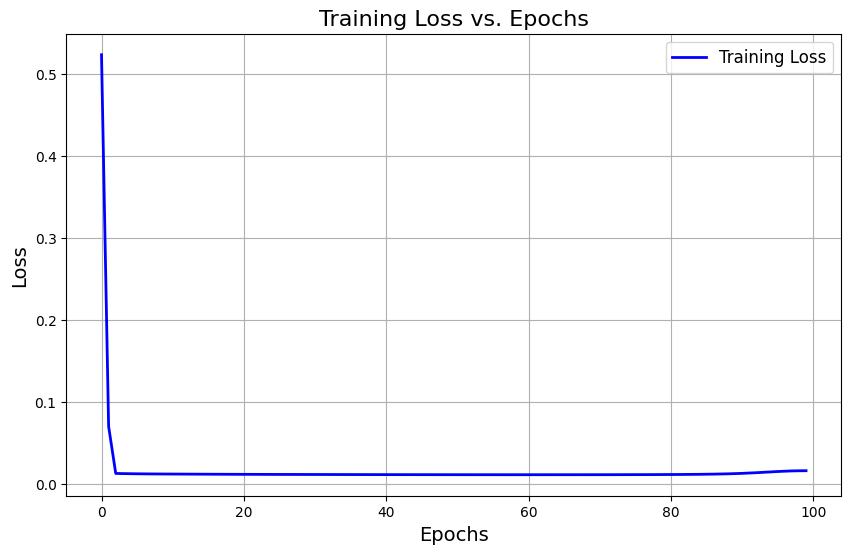

In [42]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)

# Annotating the plot
plt.title('Training Loss vs. Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [43]:
Y_pred = lstm.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


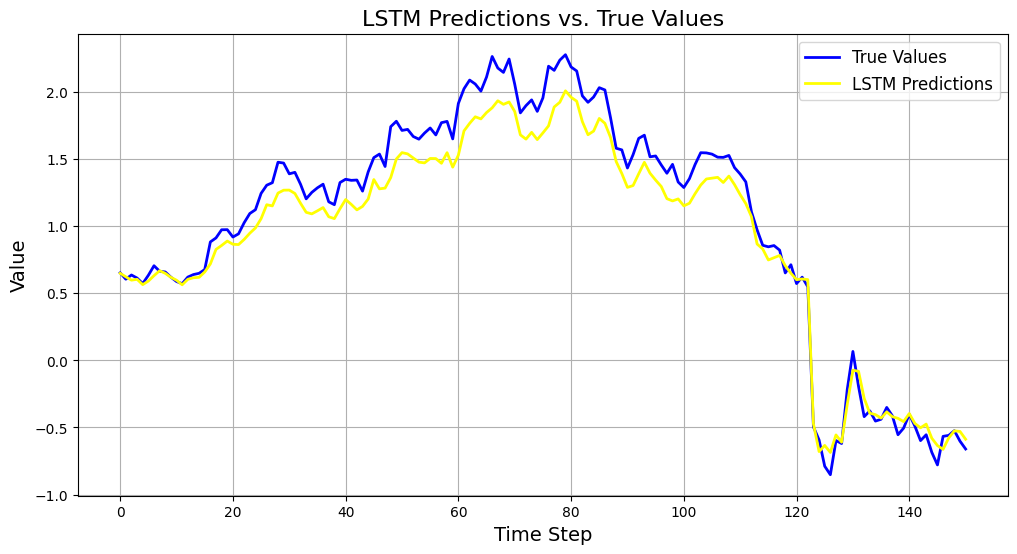

In [44]:
import matplotlib.pyplot as plt

# Ensure y_test is squeezed (flattened) if it has an extra dimension
Y_test_flat = Y_test.squeeze()
Y_pred_flat = Y_pred.squeeze()

# Plot the true values and predictions
plt.figure(figsize=(12, 6))
plt.plot(Y_test_flat, label="True Values", color="Blue", linewidth=2)
plt.plot(Y_pred_flat, label="LSTM Predictions", color="yellow", linewidth=2)

# Add labels, title, and legend
plt.title("LSTM Predictions vs. True Values", fontsize=16)
plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()



In [45]:
mse = mean_squared_error(Y_test, Y_pred_flat)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(Y_test, Y_pred_flat)
print("RMSE: ", rmse)
print("MAPE: ", mape)

RMSE:  0.17366794735269783
MAPE:  0.12597727570429854


## Increasing the Complexity of the Model

In [46]:
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),
              activation='relu', return_sequences=True))
lstm.add(LSTM(50, activation='relu', return_sequences=True))
lstm.add(LSTM(50, activation='relu'))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 1, 50)          │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,251 (200.20 KB)

 Trainable params: 51,251 (200.20 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history=lstm.fit(X_train, Y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

Epoch 1/100
152/152 - 3s - 21ms/step - loss: 0.6503
Epoch 2/100
152/152 - 1s - 5ms/step - loss: 0.0261
Epoch 3/100
152/152 - 1s - 3ms/step - loss: 0.0136
Epoch 4/100
152/152 - 0s - 3ms/step - loss: 0.0104
Epoch 5/100
152/152 - 0s - 2ms/step - loss: 0.0088
Epoch 6/100
152/152 - 0s - 2ms/step - loss: 0.0078
Epoch 7/100
152/152 - 1s - 4ms/step - loss: 0.0071
Epoch 8/100
152/152 - 0s - 3ms/step - loss: 0.0066
Epoch 9/100
152/152 - 0s - 3ms/step - loss: 0.0062
Epoch 10/100
152/152 - 0s - 2ms/step - loss: 0.0058
Epoch 11/100
152/152 - 0s - 3ms/step - loss: 0.0055
Epoch 12/100
152/152 - 0s - 3ms/step - loss: 0.0052
Epoch 13/100
152/152 - 0s - 3ms/step - loss: 0.0050
Epoch 14/100
152/152 - 0s - 3ms/step - loss: 0.0048
Epoch 15/100
152/152 - 1s - 6ms/step - loss: 0.0047
Epoch 16/100
152/152 - 1s - 4ms/step - loss: 0.0045
Epoch 17/100
152/152 - 0s - 3ms/step - loss: 0.0045
Epoch 18/100
152/152 - 0s - 3ms/step - loss: 0.0043
Epoch 19/100
152/152 - 1s - 4ms/step - loss: 0.0043
Epoch 20/100
152/152

In [48]:
Y_pred = lstm.predict(X_test)

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step


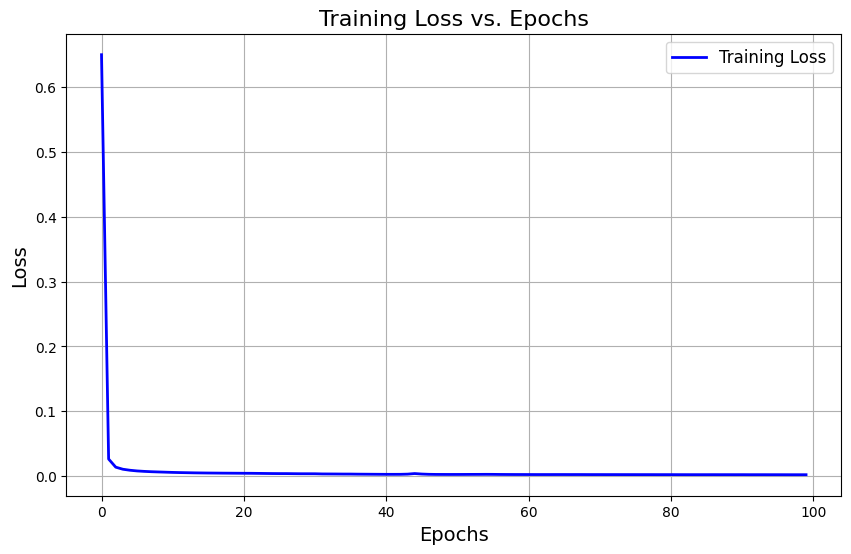

In [49]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)

# Annotating the plot
plt.title('Training Loss vs. Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

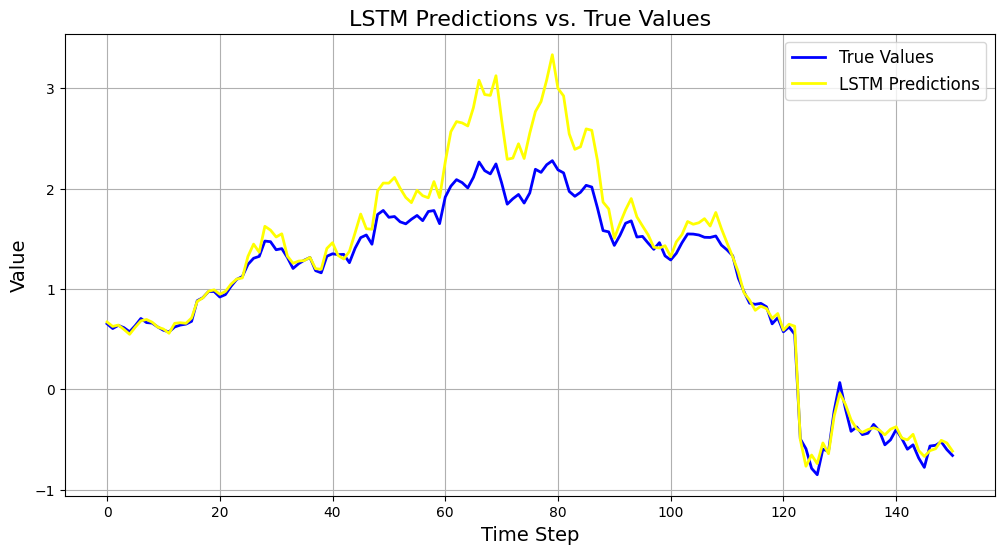

In [50]:
# Ensure y_test is squeezed (flattened) if it has an extra dimension
Y_test_flat = Y_test.squeeze()
Y_pred_flat = Y_pred.squeeze()

# Plot the true values and predictions
plt.figure(figsize=(12, 6))
plt.plot(Y_test_flat, label="True Values", color="Blue", linewidth=2)
plt.plot(Y_pred_flat, label="LSTM Predictions", color="yellow", linewidth=2)

# Add labels, title, and legend
plt.title("LSTM Predictions vs. True Values", fontsize=16)
plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()



In [52]:
mse = mean_squared_error(Y_test, Y_pred_flat)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(Y_test, Y_pred_flat)
print("RMSE: ", rmse)
print("MAPE: ", mape)

RMSE:  0.29912962402126864
MAPE:  0.12982996463181698


## Increasing the Number of Steps

In [60]:
n_steps=10
X1, Y1 = lstm_split(stock_data_ft.values, n_steps=n_steps)
train_split=0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = stock_data_ft.index
X_train, X_test = X1[:split_idx], X1[split_idx:]
Y_train, Y_test = Y1[:split_idx], Y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:-n_steps]
print(X1.shape, X_train.shape, X_test.shape, X_test_date.shape, Y_test.shape)

(748, 10, 3) (599, 10, 3) (149, 10, 3) (149,) (149,)


In [54]:
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),
              activation='relu', return_sequences=True))
lstm.add(LSTM(50, activation='relu', return_sequences=True))
lstm.add(LSTM(50, activation='relu'))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,251 (200.20 KB)

 Trainable params: 51,251 (200.20 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
history=lstm.fit(X_train, Y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

Epoch 1/100
150/150 - 4s - 29ms/step - loss: 0.1724
Epoch 2/100
150/150 - 1s - 8ms/step - loss: 0.0538
Epoch 3/100
150/150 - 1s - 8ms/step - loss: 0.0392
Epoch 4/100
150/150 - 1s - 9ms/step - loss: 0.0363
Epoch 5/100
150/150 - 1s - 9ms/step - loss: 0.0375
Epoch 6/100
150/150 - 2s - 11ms/step - loss: 0.0347
Epoch 7/100
150/150 - 2s - 11ms/step - loss: 0.0324
Epoch 8/100
150/150 - 1s - 8ms/step - loss: 0.0324
Epoch 9/100
150/150 - 1s - 9ms/step - loss: 0.0333
Epoch 10/100
150/150 - 1s - 9ms/step - loss: 0.0309
Epoch 11/100
150/150 - 1s - 9ms/step - loss: 0.0295
Epoch 12/100
150/150 - 1s - 9ms/step - loss: 0.0287
Epoch 13/100
150/150 - 2s - 13ms/step - loss: 0.0273
Epoch 14/100
150/150 - 2s - 16ms/step - loss: 0.0244
Epoch 15/100
150/150 - 2s - 12ms/step - loss: 0.0231
Epoch 16/100
150/150 - 2s - 12ms/step - loss: 0.0196
Epoch 17/100
150/150 - 1s - 10ms/step - loss: 0.0163
Epoch 18/100
150/150 - 1s - 9ms/step - loss: 0.0135
Epoch 19/100
150/150 - 1s - 8ms/step - loss: 0.0128
Epoch 20/100


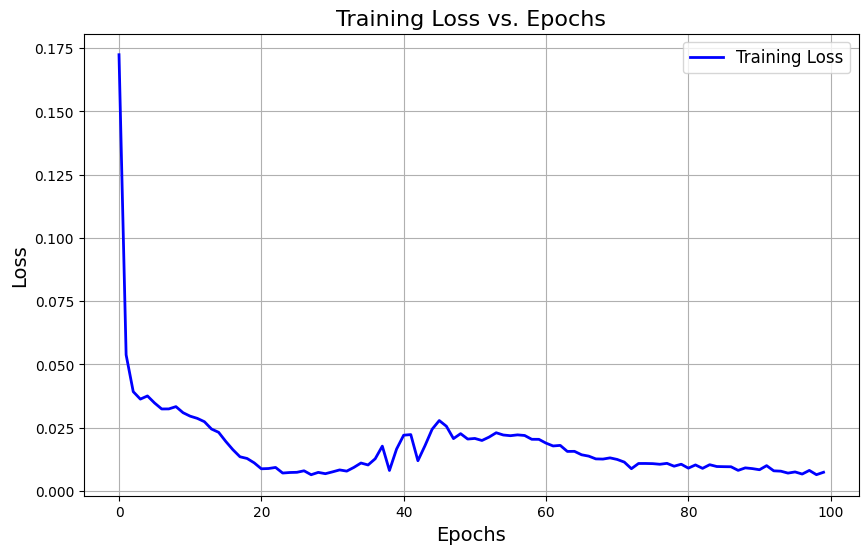

In [62]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)

# Annotating the plot
plt.title('Training Loss vs. Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [63]:
Y_pred = lstm.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


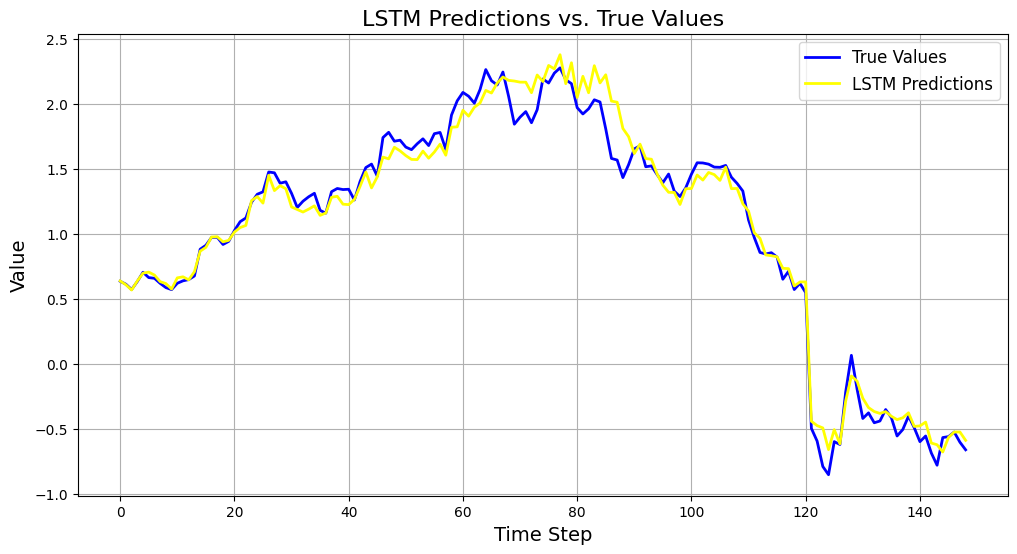

In [64]:
# Ensure y_test is squeezed (flattened) if it has an extra dimension
Y_test_flat = Y_test.squeeze()
Y_pred_flat = Y_pred.squeeze()

# Plot the true values and predictions
plt.figure(figsize=(12, 6))
plt.plot(Y_test_flat, label="True Values", color="Blue", linewidth=2)
plt.plot(Y_pred_flat, label="LSTM Predictions", color="yellow", linewidth=2)

# Add labels, title, and legend
plt.title("LSTM Predictions vs. True Values", fontsize=16)
plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [65]:
mse = mean_squared_error(Y_test, Y_pred_flat)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(Y_test, Y_pred_flat)
print("RMSE: ", rmse)
print("MAPE: ", mape)

RMSE:  0.1238714510430177
MAPE:  0.09054999681242025
